Create common Pandas Dataframe with all Data to do further analysis

In [30]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

DATA_DIR = "/workspaces/bakery_sales_prediction/0_DataPreparation/raw-data"

## Holidays for SH
- Request Holidays from API
- Combine single dataframe with the holidays

In [2]:
all_holidays = []

for year in range(2013, 2020):
    holidays = pd.read_json(f'https://feiertage-api.de/api/?jahr={year}&nur_land=SH').T
    for holiday_name, row in holidays.iterrows():
        all_holidays.append({
        'datum': row['datum'],
        'holiday_name': holiday_name
        })
    
df_holiday = pd.DataFrame(all_holidays)
df_holiday['datum'] = pd.to_datetime(df_holiday['datum'])
df_holiday = df_holiday.sort_values('datum')

In [3]:
# Load the CSV files
# file1 = f'{DATA_DIR}/umsatzdaten_gekuerzt.csv'
file2 = f'{DATA_DIR}/wetter.csv'
file3 = f'{DATA_DIR}/kiwo.csv'
file4 = f'{DATA_DIR}/holidays.school.sh.csv'
file5 = f'{DATA_DIR}/holstein_kiel.csv'
file6 = f'{DATA_DIR}/thw_kiel_heimspiel.csv'
# umsatz = pd.read_csv(file1)
wetter = pd.read_csv(file2, parse_dates=['Datum'])
kiwo = pd.read_csv(file3, parse_dates=['Datum'])
school_holidays = pd.read_csv(file4, sep=";", usecols=["StartDate","EndDate","Name"], parse_dates=["StartDate","EndDate"], dtype = {'Name': 'string'})
holstein_kiel = pd.read_csv(file5, sep=";", index_col=False, parse_dates=['Datum'], usecols=["Datum","Heimspiel"], dayfirst=True)
thw_kiel = pd.read_csv(file6, sep=";", parse_dates=['Datum'], dayfirst=True)

# print(wetter['Wettercode'].value_counts())

# print(wetter.info())
# print(kiwo.info())
# print(school_holidays.info())
# print(holstein_kiel.info())
# print(thw_kiel.info())


In [4]:
niederschlag_art_codes = {
    # "Kein Niederschlag": [0, 1, 2, 3, 5, 10, 13, 17, 20, 21, 22, 25, 26, 28, 29, 43, 45, 47, 49],
    "Regen": [51, 53, 55, 58, 60, 61, 63, 65, 80, 81, 91],
    "Schnee": [71, 72, 73, 75, 77, 78, 85],
    "Gemischt": [68, 69, 79, 95]
}

niederschlag_art_number = {
    "Regen": 1,
    "Schnee": 2,
    "Gemischt": 3
}

niederschlag_intensität_codes = {
    "Leicht": [51, 60, 61, 68, 71, 80, 85],
    "Mittel": [53, 63, 69, 73, 81],
    "Stark": [55, 65, 75]    
}

niederschlag_intensität_number = {
    "Leicht": 1,
    "Mittel": 2,
    "Stark": 3 
}

gewitter_codes = [91, 95]

In [5]:
def kategorisiere_temperatur(temperatur, monat):
    if monat in [12, 1, 2]:  # Winter
        if temperatur < -2:
            return 0
        elif -2 <= temperatur <= 5:
            return 1
        else:
            return 2
    elif monat in [3, 4, 5, 9, 10, 11]:  # Frühling/Herbst
        if temperatur < 8:
            return 0
        elif 8 <= temperatur <= 15:
            return 1
        else:
            return 2
    else:  # Sommer
        if temperatur < 16:
            return 0
        elif 16 <= temperatur <= 22:
            return 1
        else:
            return 2

def get_niederschlag_art(code):
    for key, values in niederschlag_art_codes.items():
        if code in values:
            return key
    return "Kein Niederschlag"

def get_niederschlag_intensität(code):
    for key, values in niederschlag_intensität_codes.items():
        if code in values:
            return key
    return "Keine"

def is_gewitter(code):
    return 1 if code in gewitter_codes else 0

def get_category_number(code, category_dict, number_dict):
    # Iterate through the dictionary
    for category, codes in category_dict.items():
        if code in codes:  # Check if the code exists in the list
            return number_dict[category]  # Return the corresponding number
    return 0  # Return None if no match is found

### Anpassung Wetterdaten

In [6]:
train_df = pd.read_csv(f'{DATA_DIR}/train.csv', parse_dates=['Datum'])
test_df = pd.read_csv(f'{DATA_DIR}/test.csv', parse_dates=['Datum'])

concatenated = pd.concat([train_df, test_df])

In [7]:
merged_df = concatenated.copy()

merged_df = pd.merge(merged_df, wetter, on='Datum', how='left')

merged_df['wochentag'] = merged_df['Datum'].dt.dayofweek
merged_df['is_niederschlag'] = merged_df['Wettercode'].apply(lambda x: get_category_number(x, niederschlag_art_codes, niederschlag_art_number))
merged_df['niederschlag_intesitaet'] = merged_df['Wettercode'].apply(lambda x: get_category_number(x, niederschlag_intensität_codes, niederschlag_intensität_number))
merged_df['is_gewitter'] = merged_df['Wettercode'].apply(lambda x: is_gewitter(x)) 
merged_df['temperatur_cat'] = merged_df.apply(lambda row: kategorisiere_temperatur(row['Temperatur'], row['Datum'].month), axis=1)
merged_df = merged_df.drop(columns=['Wettercode'])

Merge data sets

In [8]:
# Merge the datasets on the "Datum" column
merged_df = pd.merge(merged_df, kiwo, on='Datum', how='left')
merged_df = merged_df.rename(columns={"KielerWoche": "is_kielerWoche"})
merged_df['is_kielerWoche'] = merged_df['is_kielerWoche'].fillna(0)

merged_df = pd.merge(merged_df, df_holiday, left_on='Datum', right_on="datum", how='left')
merged_df.drop('datum', axis=1, inplace=True)
merged_df['is_holiday'] = np.where(merged_df['holiday_name'].notna(), 1, merged_df['holiday_name'])
merged_df['is_holiday'] = merged_df['is_holiday'].fillna(0)

merged_df['holiday_name'] = merged_df['holiday_name'].replace(np.nan, 'None')


merged_df = pd.merge(merged_df, thw_kiel, on='Datum', how='left')
merged_df = merged_df.rename(columns={"Heimspiel": "is_heimspiel_thw"})
merged_df['is_heimspiel_thw'] = merged_df['is_heimspiel_thw'].fillna(0)
merged_df = pd.merge(merged_df, holstein_kiel, on='Datum', how='left')
merged_df = merged_df.rename(columns={"Heimspiel": "is_heimspiel_holstein"})
merged_df['is_heimspiel_holstein'] = merged_df['is_heimspiel_holstein'].fillna(0)

/tmp/ipykernel_5442/3510322726.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['is_holiday'] = merged_df['is_holiday'].fillna(0)


In [9]:
school_holidays['EndDate'] = school_holidays['EndDate'].fillna(school_holidays['StartDate'])
school_holidays['Name'] = school_holidays['Name'].str.extract(pat = '(\w+(?=,EN))')

def check_holiday(date):
    holiday = school_holidays[(school_holidays['StartDate'] <= date) & (date <= school_holidays['EndDate'])]
    if not holiday.empty:
        return True, holiday['Name'].values[0]
    else:
        return False, 'None'

# Apply the function to each row in merged_df
merged_df[['is_school_holidays', 'school_holiday_name']] = merged_df['Datum'].apply(check_holiday).tolist()

# Convert is_school_holidays to boolean
merged_df['is_school_holidays'] = merged_df['is_school_holidays'].astype(bool)

merged_df.info()

<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_5442/939914686.py:2: SyntaxWarning: invalid escape sequence '\w'
  school_holidays['Name'] = school_holidays['Name'].str.extract(pat = '(\w+(?=,EN))')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11164 entries, 0 to 11163
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       11164 non-null  int64         
 1   Datum                    11164 non-null  datetime64[ns]
 2   Warengruppe              11164 non-null  int64         
 3   Umsatz                   9334 non-null   float64       
 4   Bewoelkung               11029 non-null  float64       
 5   Temperatur               11083 non-null  float64       
 6   Windgeschwindigkeit      11083 non-null  float64       
 7   wochentag                11164 non-null  int32         
 8   is_niederschlag          11164 non-null  int64         
 9   niederschlag_intesitaet  11164 non-null  int64         
 10  is_gewitter              11164 non-null  int64         
 11  temperatur_cat           11164 non-null  int64         
 12  is_kielerWoche           11164 n

In [10]:
# def abstand_zu_weihnachten(datum):
#     if not isinstance(datum, pd.Timestamp):
#         datum = pd.to_datetime(datum)
#     
#     jahr = datum.year
#     weihnachten = pd.Timestamp(year=jahr, month=12, day=25)
#     dreikoenig = pd.Timestamp(year=jahr+1, month=1, day=6)
#     
#     if datum <= dreikoenig:
#         weihnachten = pd.Timestamp(year=jahr-1, month=12, day=25)
#     elif datum > weihnachten:
#         weihnachten = pd.Timestamp(year=jahr+1, month=12, day=25)
#     
#     return abs((datum - weihnachten).days)
# 
# merged_df['Datum'] = pd.to_datetime(merged_df['Datum'])
# 
# # Anwenden der Funktion auf jede Zeile
# merged_df['Abstand_zu_Weihnachten'] = merged_df['Datum'].apply(abstand_zu_weihnachten)

In [11]:
# merged_train_df = pd.merge(train_df, merged_df, on='Datum', how='left')
# 
# merged_train_df['is_niederschlag'] = merged_train_df['is_niederschlag'].astype(bool)
# merged_train_df['is_gewitter'] = merged_train_df['is_gewitter'].astype(bool)
# merged_train_df['is_kielerWoche'] = merged_train_df['is_kielerWoche'].astype(bool)
# merged_train_df['is_holiday'] = merged_train_df['is_holiday'].astype(bool)
# merged_train_df['is_heimspiel_thw'] = merged_train_df['is_heimspiel_thw'].astype(bool)
# merged_train_df['is_heimspiel_holstein'] = merged_train_df['is_heimspiel_holstein'].astype(bool)
# merged_train_df['is_school_holidays'] = merged_train_df['is_school_holidays'].astype(bool)
# 
# merged_train_df['Bewoelkung'] = merged_train_df['Bewoelkung'].astype(int)
# merged_train_df['wochentag'] = merged_train_df['wochentag'].astype(int)
# merged_train_df['niederschlag_intesitaet'] = merged_train_df['niederschlag_intesitaet'].astype(int)
# merged_train_df['temperatur_cat'] = merged_train_df['temperatur_cat'].astype(int)
# merged_train_df['wochentag'] = merged_train_df['wochentag'].astype(int)
# 
# merged_train_df['holiday_name'] = merged_train_df['holiday_name'].astype(str)
# merged_train_df['school_holiday_name'] = merged_train_df['school_holiday_name'].astype(str)
# 
# merged_train_df()

Create overview about missing data

In [ ]:
import matplotlib.pyplot as plt

# Prepare data for visualization
columns = merged_df.columns.drop('Datum')  # Exclude the date column
dates = pd.to_datetime(merged_df['Datum'])

# Create a binary representation for data presence (1 if data is present, 0 otherwise)
presence_data = merged_df[columns].notna().astype(int)
presence_data['Datum'] = dates

# Reshape data for plotting
melted_data = presence_data.melt(id_vars='Datum', var_name='Column', value_name='Has Data')

# Plotting
plt.figure(figsize=(15, 8))
for i, column in enumerate(columns):
    column_data = melted_data[melted_data['Column'] == column]
    plt.scatter(
        column_data['Datum'], 
        [i] * len(column_data), 
        c=column_data['Has Data'], 
        cmap='coolwarm', 
        label=column, 
        marker='|'
    )

# Customizing the plot
plt.yticks(range(len(columns)), columns)
plt.xlabel("Date")
plt.ylabel("Columns")
plt.title("Data Presence Across Columns Over Time")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.legend(title="Columns", loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
plt.tight_layout()
plt.show()


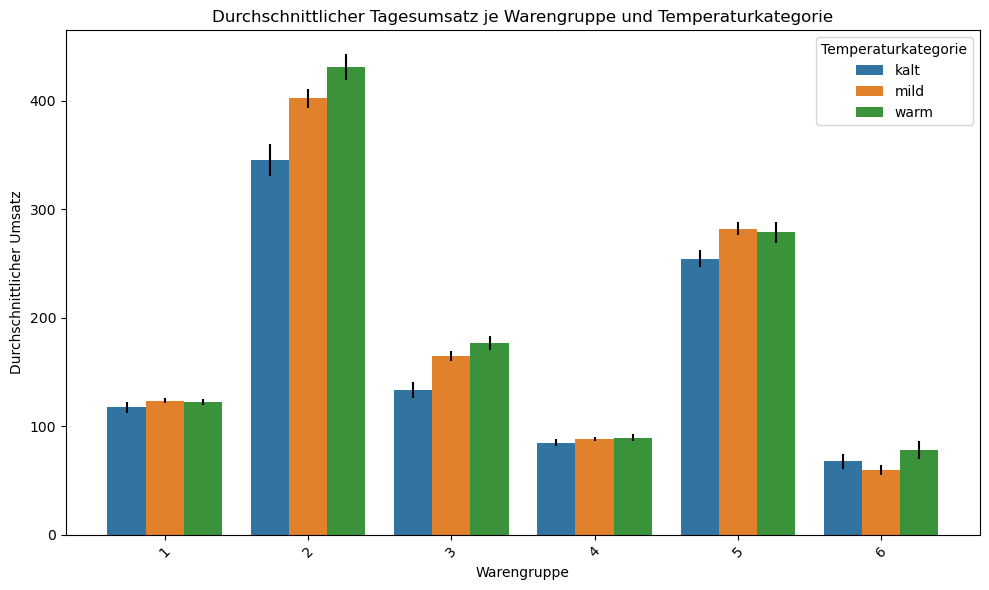

In [38]:
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

# Kopie des ursprünglichen DataFrames erstellen
temp_df = merged_df.copy()

# Dictionary für das Mapping der Temperaturkategorien und Warengruppen
temp_mapping = {0: 'kalt', 1: 'mild', 2: 'warm'}
waren_mapping = {
    1: 'Bread',
    2: 'Rolls',
    3: 'Croissant',
    4: 'Confectionery',
    5: 'Cake',
    6: 'Seasonal Bread'
}

# Labels für Temperaturkategorien und Warengruppen hinzufügen
temp_df['temperatur_cat_label'] = temp_df['temperatur_cat'].map(temp_mapping)
temp_df['Warengruppe_label'] = temp_df['Warengruppe'].map(waren_mapping)

# Gruppierung mit den neuen Labels
grouped = temp_df.groupby(['Warengruppe', 'temperatur_cat_label']).agg({
    'Umsatz': ['mean', 'std', 'count']
}).reset_index()
grouped.columns = ['Warengruppe_label', 'temperatur_cat_label', 'Umsatz_mean', 'Umsatz_std', 'Anzahl']

# Konfidenzintervall berechnen (95% CI)
konfidenzniveau = 0.95
z_score = norm.ppf((1 + konfidenzniveau) / 2)
grouped['Standardfehler'] = grouped['Umsatz_std'] / np.sqrt(grouped['Anzahl'])
grouped['CI_lower'] = grouped['Umsatz_mean'] - z_score * grouped['Standardfehler']
grouped['CI_upper'] = grouped['Umsatz_mean'] + z_score * grouped['Standardfehler']

# Plot erstellen
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Warengruppe_label', y='Umsatz_mean', hue='temperatur_cat_label', data=grouped)

# Konfidenzintervalle hinzufügen
for idx, row in grouped.iterrows():
    product_num = list(grouped['Warengruppe_label'].unique()).index(row['Warengruppe_label'])
    category_num = list(temp_mapping.values()).index(row['temperatur_cat_label'])
    
    # Berechnung der x-Position für Fehlerbalken
    x_position = product_num + (category_num - (len(temp_mapping) - 1) / 2) * (0.8 / len(temp_mapping))
    
    plt.errorbar(x=x_position, y=row['Umsatz_mean'],
                 yerr=[[row['Umsatz_mean'] - row['CI_lower']], [row['CI_upper'] - row['Umsatz_mean']]],
                 fmt='none', c='black')

plt.title('Durchschnittlicher Tagesumsatz je Warengruppe und Temperaturkategorie')
plt.xlabel('Warengruppe')
plt.ylabel('Durchschnittlicher Umsatz')
plt.legend(title='Temperaturkategorie')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


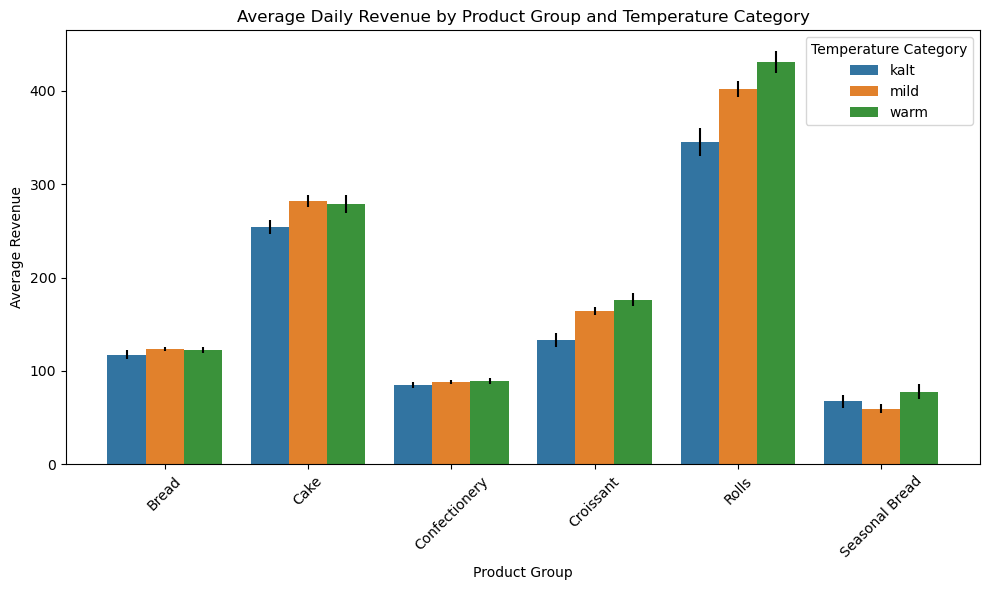

In [34]:
import numpy as np
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt

temp_df = merged_df.copy()

# Mappings für Temperaturkategorien und Warengruppen
temp_mapping = {0: 'kalt', 1: 'mild', 2: 'warm'}
waren_mapping = {
    1: 'Bread',
    2: 'Rolls',
    3: 'Croissant',
    4: 'Confectionery',
    5: 'Cake',
    6: 'Seasonal Bread'
}

# Labels hinzufügen
temp_df['temperatur_cat_label'] = temp_df['temperatur_cat'].map(temp_mapping)
temp_df['Warengruppe_label'] = temp_df['Warengruppe'].map(waren_mapping)

# Gruppierung mit den neuen Labels
grouped = temp_df.groupby(['Warengruppe_label', 'temperatur_cat_label']).agg({
    'Umsatz': ['mean', 'std', 'count']
}).reset_index()
grouped.columns = ['Warengruppe', 'temperatur_cat_label', 'Umsatz_mean', 'Umsatz_std', 'Anzahl']

# Konfidenzintervall berechnen (95% CI)
konfidenzniveau = 0.95
z_score = norm.ppf((1 + konfidenzniveau) / 2)
grouped['Standardfehler'] = grouped['Umsatz_std'] / np.sqrt(grouped['Anzahl'])
grouped['CI_lower'] = grouped['Umsatz_mean'] - z_score * grouped['Standardfehler']
grouped['CI_upper'] = grouped['Umsatz_mean'] + z_score * grouped['Standardfehler']

# Plot erstellen
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Warengruppe', y='Umsatz_mean', hue='temperatur_cat_label', data=grouped)

# Konfidenzintervalle hinzufügen
num_groups = len(grouped['Warengruppe'].unique())
num_categories = len(grouped['temperatur_cat_label'].unique())
width = 0.8

for idx, row in grouped.iterrows():
    product_num = list(grouped['Warengruppe'].unique()).index(row['Warengruppe'])
    category_num = list(temp_mapping.values()).index(row['temperatur_cat_label'])
    
    x_position = product_num + (category_num - (num_categories-1)/2) * (width/num_categories)
    
    plt.errorbar(x=x_position, y=row['Umsatz_mean'],
                yerr=[[row['Umsatz_mean'] - row['CI_lower']], [row['CI_upper'] - row['Umsatz_mean']]],
                fmt='none', c='black')

plt.title('Average Daily Revenue by Product Group and Temperature Category')
plt.xlabel('Product Group')
plt.ylabel('Average Revenue')
plt.legend(title='Temperature Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

save common data frame

In [12]:
# Save the merged dataframe to a CSV file
# now = datetime.now()
save_path = f'/workspaces/bakery_sales_prediction/0_DataPreparation/01_merged_data.csv'
merged_df.to_csv(save_path, index=False)

print(merged_df.info())
print(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11164 entries, 0 to 11163
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       11164 non-null  int64         
 1   Datum                    11164 non-null  datetime64[ns]
 2   Warengruppe              11164 non-null  int64         
 3   Umsatz                   9334 non-null   float64       
 4   Bewoelkung               11029 non-null  float64       
 5   Temperatur               11083 non-null  float64       
 6   Windgeschwindigkeit      11083 non-null  float64       
 7   wochentag                11164 non-null  int32         
 8   is_niederschlag          11164 non-null  int64         
 9   niederschlag_intesitaet  11164 non-null  int64         
 10  is_gewitter              11164 non-null  int64         
 11  temperatur_cat           11164 non-null  int64         
 12  is_kielerWoche           11164 n